# **Hydrogen Atom in a Uniform Magnetic Field**

In this notebook, we will investigate the effect of a uniform magnetic field in the $z$ direction on the electronic transitions of the Hydrogen atom. We typically assume that $m_l$ and $m_s$ don't have any effect on electronic transitions (i.e. which sub-orbital and what spin the electron begins in does not matter, as long as it starts in the same orbital), but this is not always the case.

One situation where $m_l$ and $m_s$ must be considered in the energy of the electronic transition is when a uniform magnetic field is applied to the atom. Experimentally, this results in the lines of the atomic emission spectrum "splitting" into separate lines. For a Hydrogen atom, this is called the Paschen-Back effect.

### _Paschen-Back (Strong-Field) Effect_
The Paschen-Back effect applies to systems where the magnetic field is strong enough to "disrupt" the spin-orbit coupling of the atom. In our case, however, the spin-orbit coupling of Hydrogen is already negligible, so almost any magnetic field, even a weak one, will be much greater than the spin-orbit coupling of the atom. Thus, we can use this to solve for the energy of the split atomic energy levels with the following Hamiltonian, which is exactly solvable:

$$
\hat{H}_{\text{z}} = -\frac{1}{2} \nabla^2 - \frac{Z}{r} + \mu_{\text{B}}Bm_{\text{j}}g_{\text{J}}
$$

This is the hydrogenic atom Hamiltonian with an added term for the magnetic potential. Using this, we can find the energy of each spectral line (note that for each original spectral line without an applied magnetic field, we will have two lines with a magnetic field applied - this is demonstrated by the energy depending on $m_l$ and $m_s$, so the two possible spin states of the electrons are accounted for).

$$
E_z = E_{\text{o}} + B_{z} \mu_B (m_l + g_s m_s)
$$

Where $E_o$ is the energy of the hydrogenic atom.

In the code below, we calculate the Zeeman energy (which is the second term in the energy expression above, and is the energy associated with the magnetic potential, we will be using the approximation $ g_s \approx 2$), then calculate the energy of the hydrogenic atom in a magnetic field. Then, the Balmer series is plotted for a hydrogenic atom in the absence of a magnetic field and in various constant magnetic fields.

In [ ]:
# Install required packages
!pip install git+https://github.com/QC-Edu/QChem-utils.git

  Cloning https://github.com/QC-Edu/QChem-utils.git to c:\users\merni\appdata\local\temp\pip-req-build-b03g1ure
  Resolved https://github.com/QC-Edu/QChem-utils.git to commit 008bc97eef519a8005aef2724326d2f242076675
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/QC-Edu/QChem-utils.git 'C:\Users\merni\AppData\Local\Temp\pip-req-build-b03g1ure'


In [ ]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants

# This gives you access to the hydrogenic energies.
from qctools.hydrogen import calc_energy

In [ ]:
def zeeman_energy(ml, ms, B):
    """
    Calculate the Zeeman energy in electron volts for a hydrogen atom in a magnetic field.

    Parameters
    ----------
    ml : int
        Magnetic quantum number.
    ms : float
        Spin quantum number.
    B : float
        Magnetic field strength in Tesla.

    Returns
    -------
    float
        The Zeeman energy in electron volts.
    """

    # Calculate the Bohr magneton
    mu_B = physical_constants['Bohr magneton in eV/T'][0]

    # Calculate the Zeeman energy
    E_Z = mu_B * B * (ml + 2 * ms)

    return E_Z

def strong_field_energy(n, ml, ms, B):
    """
    Calculate the energy in electron volts of a hydrogen atom in a strong magnetic field.

    Parameters
    ----------
    n : int
        Principal quantum number.
    ml : int
        Magnetic quantum number.
    ms : float
        Spin quantum number.
    B : float
        Magnetic field strength in Tesla.

    Returns
    -------
    float
        The strong-field energy in electron volts.
    """

    # Calculate the Zeeman energy
    E_Z = zeeman_energy(ml, ms, B)

    # Calculate the energy without the magnetic field
    E = calc_energy(n, Z=1, units='eV')

    # Calculate the energy in a strong magnetic field
    E_strong = E + E_Z

    return E_strong

Below are some "housekeeping" functions to properly plot the Balmer series. We are only considering the electric dipole-allowed transitions; the selection rules are as follows: 

$ \Delta l = \pm 1 ; \Delta m_l = 0, \pm 1 ; \Delta m_s = 0 $


In [ ]:
def energy_to_wavelength(E):
    """
    Convert energy to wavelength.

    Parameters
    ----------
    E : float
        Energy in electron volts.

    Returns
    -------
    float
        Wavelength in nanometers.
    """
    return 1e9 * physical_constants['Planck constant in eV s'][0] * physical_constants['speed of light in vacuum'][0] / E

def dipole_allowed_transitions(n_low, n_high):
    """
    Calculate the dipole-allowed transitions for hydrogen.

    Parameters
    ----------
    n_low : int
        Lower principal quantum number.
    n_high : int
        Higher principal quantum number.

    Returns
    -------
    transitions : dict
        A dictionary containing the allowed transitions.
    """
    # Initialize the dictonary of dipole-allowed transitions
    transitions = {}

    # Loop over all quantum numbers
    for l_high in range(0, n_high):
        for ml_high in range(-l_high, l_high+1):
            for ms_high in (-1/2, 1/2):
                for l_low in range(0, n_low):
                    for ml_low in range(-l_low, l_low+1):
                        for ms_low in (-1/2, 1/2):

                            # Check if the transition is dipole-allowed by selection rules
                            if abs(l_high - l_low) == 1 and ms_high == ms_low and (ml_high == ml_low or abs(ml_high - ml_low) == 1):

                                # Add the transition to the dictionary
                                transitions[f'{n_high}, {l_high}, {ml_high}, {ms_high} -> {n_low}, {l_low}, {ml_low}, {ms_low}'] = (
                                    n_high, l_high, ml_high, n_low, l_low, ml_low, ms_low
                                )

    return transitions

def hydrogen_transitions(n_low, n_high, B):
    """
    Calculate the wavelengths for electronic transitions in a hydrogen atom between two energy levels.

    Parameters
    ----------
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    B : float
        Magnetic field strength in Tesla

    Returns
    -------
    wavelengths : dict
       A dictionary containing the transition wavelengths in nanometers.
    """

    # Initialize the dictonary of electronic transition wavelengths in nanometers
    wavelengths = {}

    # Get the dipole-allowed transitions
    for n in range(n_low+1, n_high+1):
        transitions = dipole_allowed_transitions(n_low, n)

        # Add the wavelength to the dictionary
        for transition in transitions.values():
            n_high, l_high, ml_high, n_low, l_low, ml_low, ms_low = transition
            wavelengths[f'{n_high}, {l_high}, {ml_high}, {ms_low} -> {n_low}, {l_low}, {ml_low}, {ms_low}'] = (
                energy_to_wavelength
                (
                    strong_field_energy(n_high, ml_high, ms_low, B) - strong_field_energy(n_low, ml_low, ms_low, B)
                )
            )

    return wavelengths

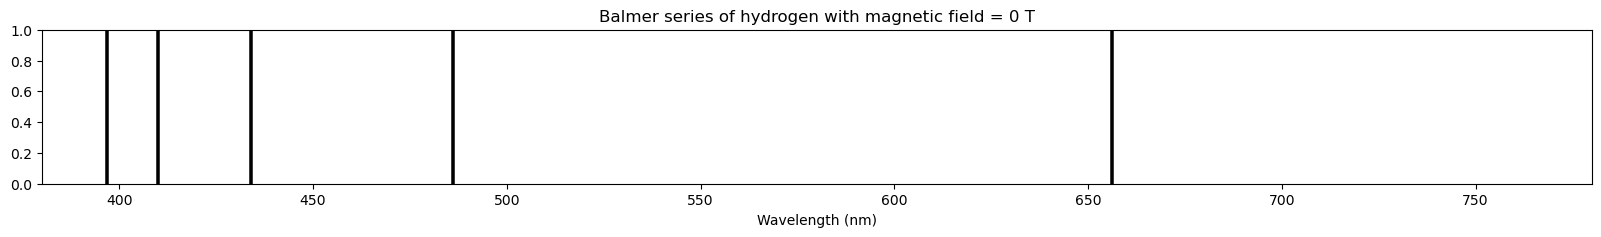

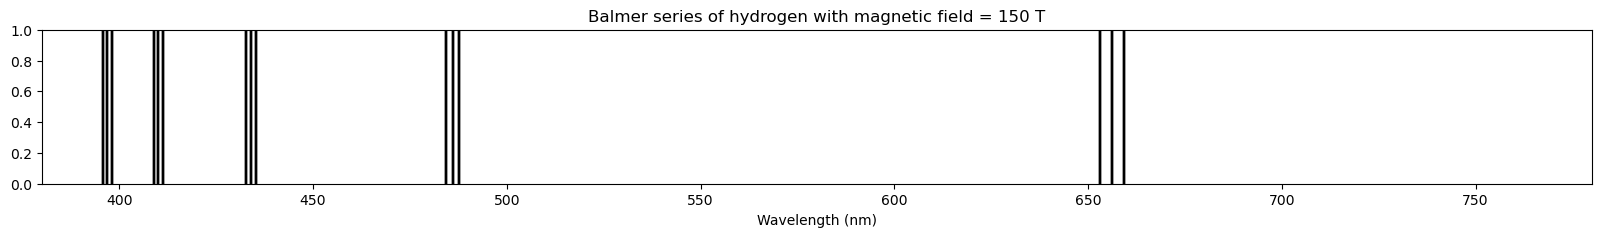

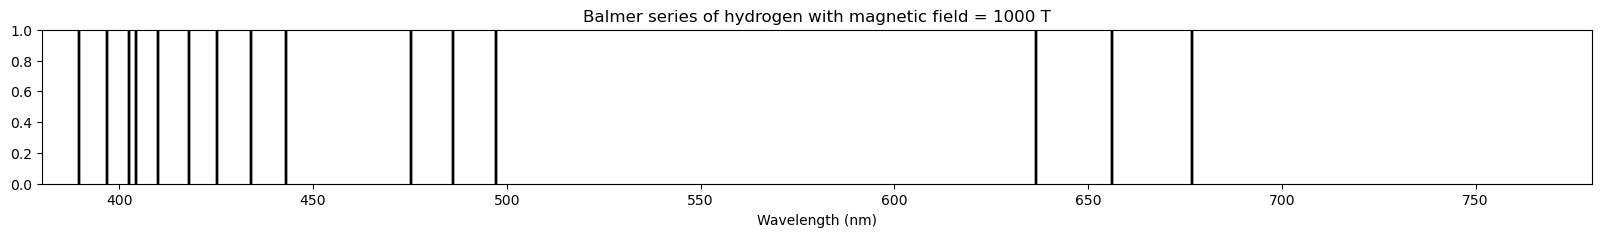

In [ ]:
def balmer_series(wavelength_range, n_low, n_high, B):
    """
    Plot the wavelengths for the Balmer series of hydrogen.

    Parameters
    ----------
    wavelength_range : tuple
        The range of the Balmer series to plot.
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    B : float
        Magnetic field strength in Tesla.

    Returns
    -------
    Plot of the Balmer series of hydrogen.
    """

    # Calculate the wavelengths for the Balmer series of hydrogen
    wavelengths = hydrogen_transitions(n_low, n_high, B).values()

    fig, axs = plt.subplots(figsize=(20, 2))
    axs.set_xlim(wavelength_range)
    axs.set_xlabel('Wavelength (nm)')
    axs.set_title(f'Balmer series of hydrogen with magnetic field = {B} T')

    for wavelength in wavelengths:
        plt.axvline(wavelength, color='black')

    plt.show()

    return

# Plot the Balmer series of hydrogen with no magnetic field.
balmer_series((380, 780), 2, 7, 0)

# Plot the Balmer series of hydrogen with a magnetic field of 150 T.
balmer_series((380, 780), 2, 7, 150)

# Plot the Balmer series of hydrogen with a magnetic field of 1000 T.
balmer_series((380, 780), 2, 7, 1000)

### _Fine-Structure Correction_

The above gives us a pretty good idea of the splitting of spectral lines in a magnetic field, but we can fine tune it even more to include the effects of the "fine-structure". The fine-structure combines residual spin-orbit coupling and relativistic effects, both of which are minimal in the hydrogen atom - this means that only the first order perturbation is enough to get an accurate picture of our splitting. This gives us a new Hamiltonian (which is beyond the scope of this course, but this (MEREDITH LINK HERE) textbook gives more information) and we can solve for the energy with a first-order perturbation:

$$
E_{\text{z + fs}} = E_{z} + {\frac {13.6 eV}{n^{3}}}\alpha^{2}\left\{{\frac {3}{4n}}-\left[{\frac {l(l+1)-m_{l}m_{s}}{l(l+1/2)(l+1)}}\right]\right\}
$$

This is calculated in the code below, with new plots of the Balmer series in different constant magnetic fields as well as a visualization of the difference that including the fine-structure makes on the spectrum.

In [ ]:
def fine_structure_correction(n, l, ml, ms):
    """
    Calculate the energy in electron volts of the first-order fine-structure correction to the hydrogen atom.

    Parameters
    ----------
    n : int
        Principal quantum number.
    l : int
        Orbital quantum number.
    ml : int
        Magnetic quantum number.
    ms : float
        Spin quantum number.

    Returns
    -------
    float
        The first-order fine-structure corrected energy in electron volts.
    """

    # Calculate the first-order fine structure correction via perturbation theory

    if l != 0:
        E_fs = ((-13.6057/n**3) * physical_constants['fine-structure constant'][0]**2
                * (3/(4 * n) - (l * (l + 1) - (ml * ms)/(l * (l + 1/2) * (l + 1)))))

    else:
        E_fs = (-13.6057/n**3) * physical_constants['fine-structure constant'][0]**2 * 3/(4 * n)

    return E_fs


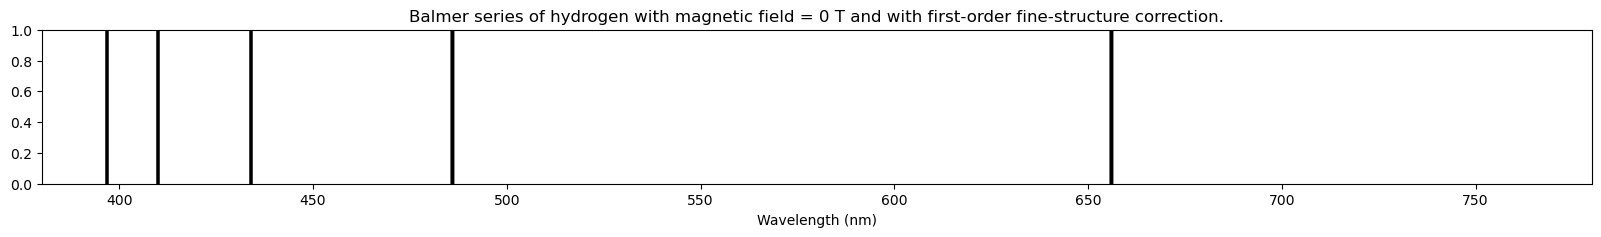

(0.5334167957961526, 0.03209020474022888)


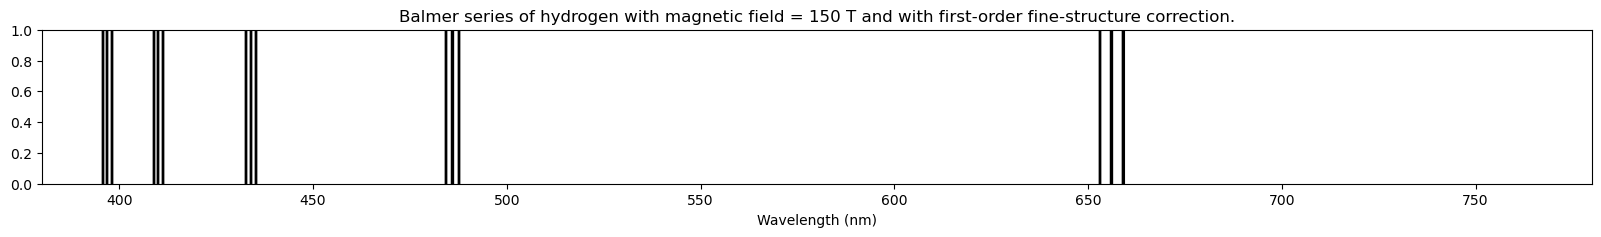

(0.5334493003738369, 0.03209115752748365)


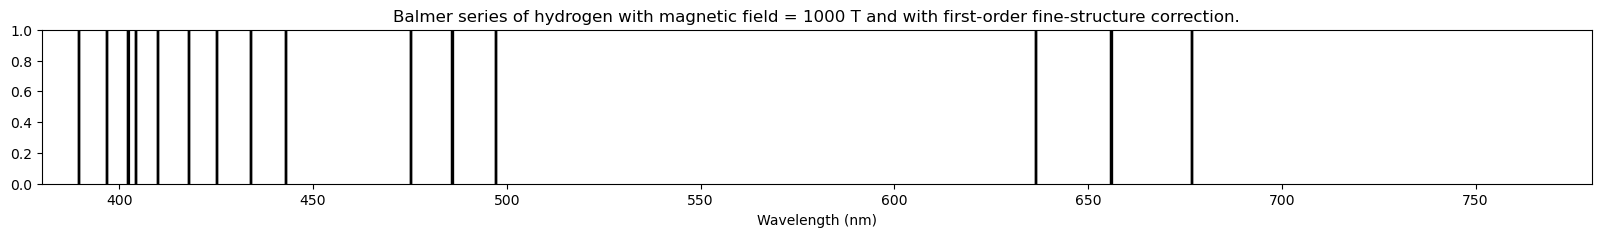

(0.5348638385152804, 0.03213260353595047)


In [ ]:
def fine_structure_hydrogen_transitions(n_low, n_high, B):
    """
    Calculate the wavelengths for electronic transitions in a hydrogen atom between two energy levels with first-order fine-structure correction.

    Parameters
    ----------
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    B : float
        Magnetic field strength in Tesla

    Returns
    -------
    wavelengths : dict
       A dictionary containing the transition wavelengths in nanometers.
    """

    # Initialize the dictonary of electronic transition wavelengths in nanometers
    wavelengths = {}

    # Get the dipole-allowed transitions
    for n in range(n_low+1, n_high+1):
        transitions = dipole_allowed_transitions(n_low, n)

        # Add the wavelength to the dictionary
        for transition in transitions.values():
            n_high, l_high, ml_high, n_low, l_low, ml_low, ms_low = transition
            wavelengths[f'{n_high}, {l_high}, {ml_high}, {ms_low} -> {n_low}, {l_low}, {ml_low}, {ms_low}'] = (
                energy_to_wavelength
                (
                    strong_field_energy(n_high, ml_high, ms_low, B) + fine_structure_correction(n_high, l_high, ml_high, ms_low)
                    - strong_field_energy(n_low, ml_low, ms_low, B) + fine_structure_correction(n_low, l_low, ml_low, ms_low)
                )
            )

    return wavelengths

def fine_structure_balmer_series(wavelength_range, n_low, n_high, B):
    """
    Plot the wavelengths for the Balmer series of hydrogen with first-order fine-structure correction.

    Parameters
    ----------
    wavelength_range : tuple
        The range of the Balmer series to plot.
    n_low : int
        The lower principal quantum number.
    n_high : int
        The higher principal quantum number.
    B : float
        Magnetic field strength in Tesla.

    Returns
    -------
    Plot of the Balmer series of hydrogen with first-order fine-structure correction.

    tuple
        float
            2-norm of the difference between the wavelengths of the Balmer series of hydrogen with and without first-order fine-structure correction.
            This is a numerical measure of the difference between the two sets of wavelengths
        float
            Average difference between the wavelengths of the Balmer series of hydrogen with and without first-order fine-structure correction.
    """

    # Calculate the wavelengths for the Balmer series of hydrogen
    wavelengths = hydrogen_transitions(n_low, n_high, B).values()
    corrected_wavelengths = fine_structure_hydrogen_transitions(n_low, n_high, B).values()

    difference = [abs(corrected_wavelength - wavelength) for corrected_wavelength, wavelength in zip(corrected_wavelengths, wavelengths)]

    fig, axs = plt.subplots(figsize=(20, 2))
    axs.set_xlim(wavelength_range)
    axs.set_xlabel('Wavelength (nm)')
    axs.set_title(f'Balmer series of hydrogen with magnetic field = {B} T and with first-order fine-structure correction.')

    for wavelength in corrected_wavelengths:
        plt.axvline(wavelength, color='black')

    plt.show()

    return np.linalg.norm(difference), np.mean(difference)

# Plot the Balmer series of hydrogen with no magnetic field and first-order fine-structure correction.
print(fine_structure_balmer_series((380, 780), 2, 7, 0))

# Plot the Balmer series of hydrogen with a magnetic field of 150 T and with first-order fine-structure correction.
print(fine_structure_balmer_series((380, 780), 2, 7, 150))

# Plot the Balmer series of hydrogen with a magnetic field of 1000 T and with first-order fine-structure correction.
print(fine_structure_balmer_series((380, 780), 2, 7, 1000))


### _Visualization_

The following visualization helps to detail how the fine-structure correction effects the degeneracy of the hydrogen atom's electric dipole-allowed transitions. As one might guess, the following two transitions correspond to the same wavelength:     

$(n = 3, l = 0, m_l = 0, m_s = 0.5) \longrightarrow (n = 2, l = 1, m_l = 0, m_s = 0.5)$

$(n = 3, l = 0, m_l = 0, m_s = -0.5) \longrightarrow (n = 2, l = 1, m_l = 0, m_s = -0.5)$

this degeneracy is retained when a magnetic field is applied. One might not guess that the following two transitions correspond to the same wavelength: 

$(n = 3, l = 0, m_l = 0, m_s = 0.5) \longrightarrow (n = 2, l = 1, m_l = -1, m_s = 0.5)$

$(n = 3, l = 0, m_l = 0, m_s = -0.5) \longrightarrow (n = 2, l = 1, m_l = 1, m_s = -0.5)$

this degeneracy is *not* retained when a magnetic field is applied. 

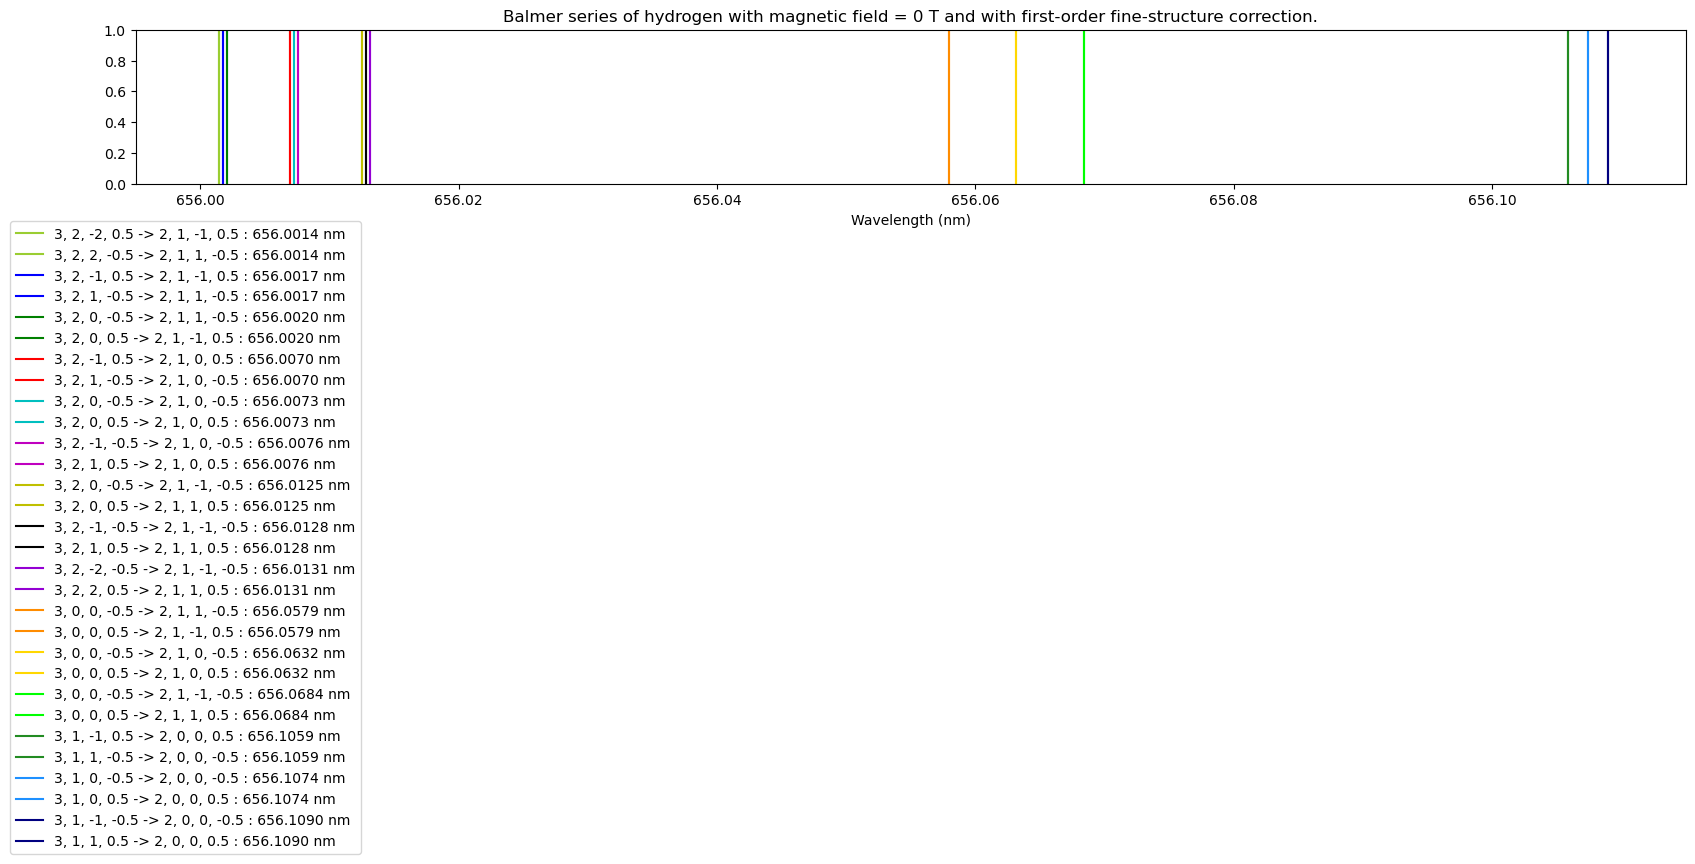

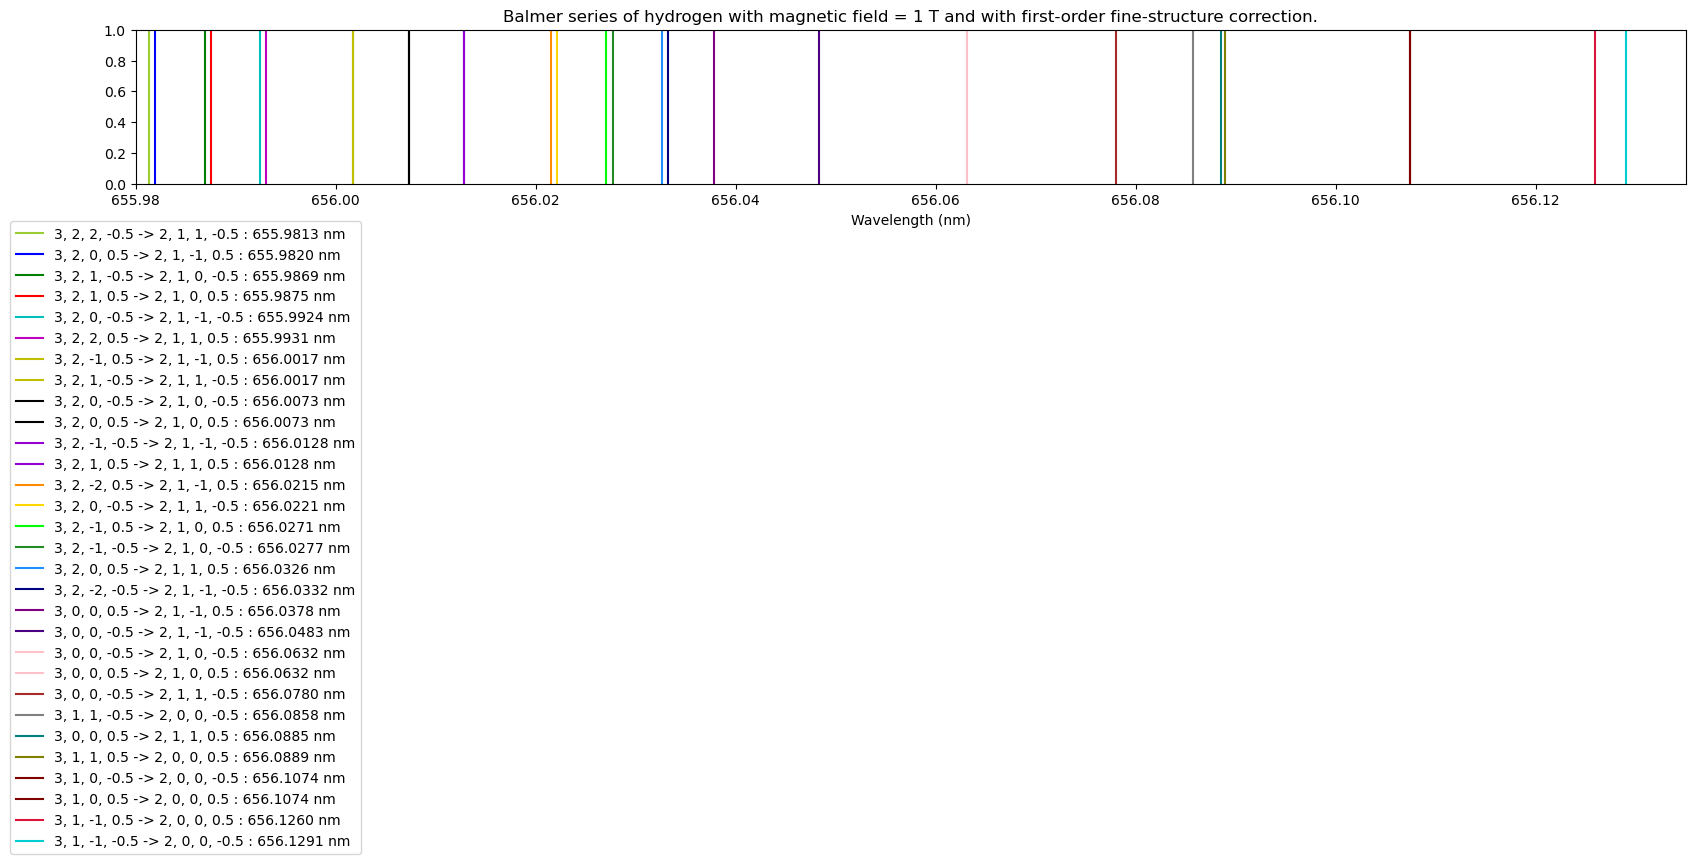

In [ ]:
def visualization(wavelength_range, B):
    """
    Visualize how the n=3 -> n=2 transition changes with addition of a magnetic field and/or first-order fine-structure correction.

    Parameters
    ----------
    wavelength_range : tuple
        The range of the Balmer series to plot.
    B : float
        Magnetic field strength in Tesla.

    Returns
    -------
    Plot of the Balmer series of hydrogen with first-order fine-structure correction.
    """

    # Sort the dictionary for easier code.
    unsort = fine_structure_hydrogen_transitions(2, 3, B)
    sort = dict(sorted(unsort.items(), key=lambda item: item[1]))

    # Extract the wavelengths and transitions.
    wavelengths = sort.values()
    transitions = sort.keys()

    # Define the colors for the plot.
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkviolet', 'darkorange', 'gold', 'lime', 'forestgreen',
              'dodgerblue', 'navy', 'purple', 'indigo', 'pink', 'brown', 'gray', 'teal', 'olive', 'maroon',
              'crimson', 'mediumslateblue', 'darkturquoise', 'darkgoldenrod', 'darkslategray', 'yellowgreen']

    # Setting-up the plot.
    fig, axs = plt.subplots(figsize=(20, 2))
    axs.set_xlim(wavelength_range)
    axs.set_xlabel('Wavelength (nm)')
    axs.set_title(f'Balmer series of hydrogen with magnetic field = {B} T and with first-order fine-structure correction.')

    # Initialize the counter for the colors.
    ctr = -1

    # Plot the transitions.
    for i in range(len(transitions)):

        plt.axvline(list(wavelengths)[i], color=colors[ctr], label=f'{list(transitions)[i]} : {list(wavelengths)[i]:.4f} nm')
        axs.legend(loc='best', bbox_to_anchor=(-0.35, -0.7, 0.5, 0.5))

        # If two transitions are degenerate, colour them the same - this is a bit messy but it works.
        if B == 0 and list(wavelengths)[i-1] == list(wavelengths)[i]:
            ctr += 1

        elif B != 0 and list(wavelengths)[i+1] != list(wavelengths)[i]:
            ctr += 1
            if ctr == 23:
                plt.axvline(list(wavelengths)[-1], color=colors[24], label=f'{list(transitions)[-1]} : {list(wavelengths)[-1]:.4f} nm')
                axs.legend(loc='best', bbox_to_anchor=(-0.35, -0.7, 0.5, 0.5))
                break

    plt.show()

    return

# Visualize the n=3 -> n=2 transition with no magnetic field and first-order fine-structure correction.
visualization((655.995, 656.115), 0)

# Visualize the n=3 -> n=2 transition with a magnetic field of 1 T and first-order fine-structure correction.
visualization((655.98, 656.135), 1)

#### **Thought-Provoking Questions (S+)**
\
**1.** *How would the Paschen-Back Effect change if the system was a particle in a spherical box rather than a hydrogenic atom?*

The major difference between a particle in a spherical box and a hydrogenic atom is the potential energy. In the hydrogenic atom discussed above, the Hamiltonian for the electron is given by $\hat{H}_{\text{el}} = -\frac{1}{2} \nabla^2 - \frac{Z}{r}$, where $-\frac{Z}{r}$ represents the Coulomb potential from the nucleus acting on the electron. Contrastingly, a particle in a spherical box does not experience attraction to a nucleus, and thus does not experience any Coulomb potential within the box. Therefore, the Hamiltonian for the particle in this system can be represented as $\hat{H}_{\text{PinSpherB}} = -\frac{1}{2} \nabla^2$.

In addition to this difference in potential energy with respect to the exactly solvable Hamiltonian prior to the application of a magnetic field, there is also a major difference in coupling. For a hydrogenic atom, spin-orbit coupling mixes L and S, requiring an approximation to account for fine-structure effects. However, in this case they are degenerate. For a particle in a spherical box, we still have L and S, but they are now not degenerate. This means that the magnetic field will have a larger impact on one of the two angular momentum terms, so there will be a greater amount of line splitting but the energy gaps between those lines will be smaller.

\
**2.** *Investigate the effect on the system if the magnetic field is replaced with an electric field.*

This would result in an electric-field analogue of the Zeeman Effect, known as the Stark effect. In the Zeeman and Paschen-Back effects, spectral line splitting is completely dependent on the strength of the applied magnetic field. However, in the Stark effect, the splitting depends on the symmetry of atomic states. An electric field will interact with an atom, hybridizing the orbitals into eigenstates of the perturbed Hamiltonian. Therefore, the electric field will be different than the magnetic field because it causes splitting based on the atomic dipole interactions, rather than the decoupling of angular momenta as a result of a magnetic field.

\
**3.** *Is there a way you could initutively explain why the following two transitions are degenerate?*

$(n = 3, l = 0, m_l = 0, m_s = 0.5) \longrightarrow (n = 2, l = 1, m_l = -1, m_s = 0.5)$

$(n = 3, l = 0, m_l = 0, m_s = -0.5) \longrightarrow (n = 2, l = 1, m_l = 1, m_s = -0.5)$

A $2p^{-1}$ orbital with a $+1/2$ spin electron is a relfection of a $2p^{+1}$ with a $-1/2$ spin electron, therefore one would expect transitions related to those quantum numbers to be degenerate.

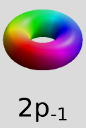 + 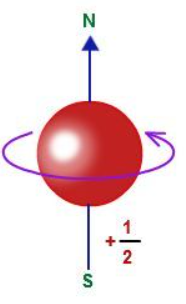 is a reflection of 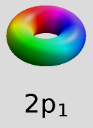 + 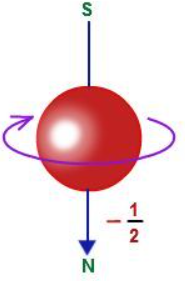 

(to get from one set to another, reflect along the yellow-blue phase of the p-orbital and along the magnetic field of the electron *and* perpendicular to the magnetic field of the electron)